In [2]:
using Pkg
Pkg.activate("..")
using Pun
using Plots

include("../examples.jl")

  Activating project at `~/Documents/code/Pun.jl`


bivgauss (generic function with 1 method)

# Basic Linear Regression Example

In [66]:
struct LinearModel
    slope::Real
    intercept::Real
end

linear_model_prior() = @prob begin
    slope <<= normal(0, 1)
    intercept <<= normal(0, 2)
    linear_model .<<= LinearModel(slope, intercept)
    slope .>>= linear_model.slope
    intercept .>>= linear_model.intercept
    return linear_model
end

bayesian_linear_regression(xs::Vector{Float64}) = @prob begin
    linear_model <<= linear_model_prior()
    
    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    y <<= mapM(x -> normal(linear_model.slope * x + linear_model.intercept, 0.1), xs)
    return y, linear_model
end

bayesian_linear_regression (generic function with 1 method)

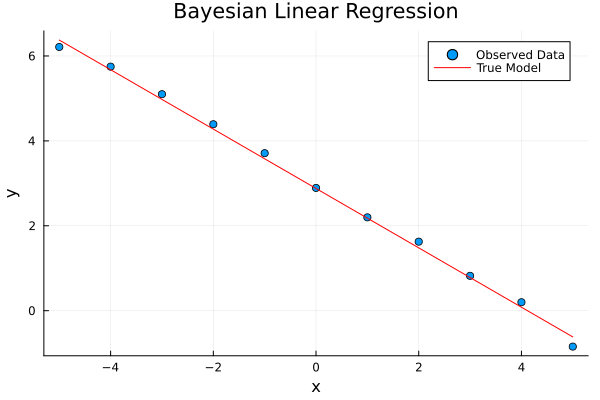

In [68]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.]
(y, linear_model), score, basis = simulate(bayesian_linear_regression(xs))

plot(xs, y, seriestype=:scatter, label="Observed Data", title="Bayesian Linear Regression", xlabel="x", ylabel="y")
plot!(xs, linear_model.slope .* xs .+ linear_model.intercept, label="True Model", color=:red)

In [69]:
model = bayesian_linear_regression(xs)
proposal = x -> model # We use the prior as the proposal distribution

Pun.importance_sampling(model, proposal, y, basis, 10)

BoundsError: BoundsError: attempt to access Tuple{} at index [1]

# Generalized Linear Regression

Now we add a sine basis function to our linear model.

In [74]:
struct SineModel
    phase::Real
    period::Real
    amplitude::Real
end

function get_sine_values(sm::SineModel, x)
    return sm.amplitude * sin(sm.period * x + sm.phase)
end

sine_model_prior(xs::Vector{Float64}) = @prob begin
    phase <<= uniform(0, 2 * π)
    period <<= uniform(0.1, 10)
    amplitude <<= normal(0, 5)
    return SineModel(phase, period, amplitude)
end

bayesian_sine_regression(xs::Vector{Float64}) = @prob begin
    sine_model <<= sine_model_prior(xs)

    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    y <<= mapM(x -> normal(get_sine_values(sine_model, x), 0.1), xs)
    return y, sine_model
end

bayesian_sine_regression (generic function with 1 method)

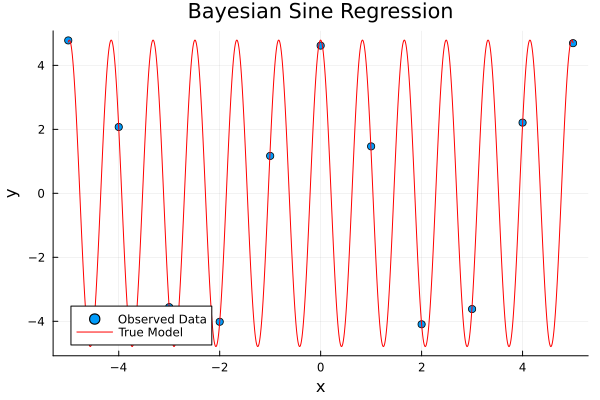

In [88]:
(y, sine_model), score, basis = simulate(bayesian_sine_regression(xs))


plot(xs, y, seriestype=:scatter, label="Observed Data", title="Bayesian Sine Regression", xlabel="x", ylabel="y")
x_ = range(-5, stop=5, step=0.01)
plot!(x_, map(x -> get_sine_values(sine_model, x), x_), label="True Model", color=:red)

## Mixed Sine and Linear Model

In [104]:
mixed_regression_model(xs::Vector{Float64}) = @prob begin
    is_linear <<= flip(0.5)
    (y, model) <<= is_linear ? bayesian_linear_regression(xs) : bayesian_sine_regression(xs)
    is_linear .>>= (typeof(model) == LinearModel)
    return y, model
end

mixed_regression_model (generic function with 1 method)

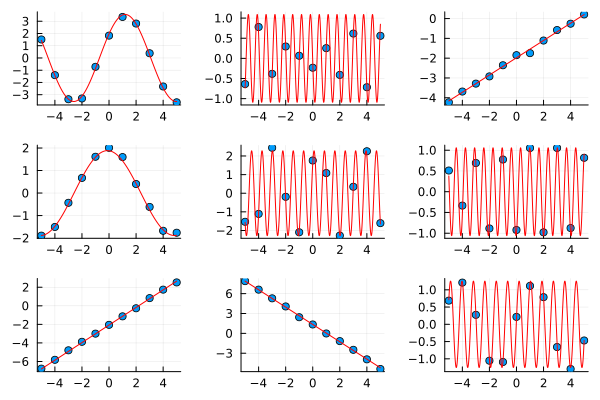

In [ ]:
figs = []
for i in 1:9
    (y, model), score, basis = simulate(mixed_regression_model(xs))
    fig = plot(xs, y, seriestype=:scatter, legend=false)
    push!(figs, fig)
    x_ = range(-5, stop=5, step=0.01)
    if typeof(model) == LinearModel
        plot!(x_, model.slope .* x_ .+ model.intercept, color=:red, legend=false)
    else
        plot!(x_, map(x -> get_sine_values(model, x), x_),  color=:red, legend=false)
    end
end

plot(figs..., layout=(3, 3))

# Nonparametric Model

In [2]:
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

generate_segments(l::Float64, u::Float64) = @prob begin
    interval = Interval(l, u)
    isleaf <<= flip(0.7)
    if isleaf
        value <<= normal(0, 1)
        isleaf .>>= true
        return LeafNode(value, interval)
    else
        frac <<= beta(2, 2)
        mid  .<<= l + (u - l) * frac
        frac .>>= (mid - l) / (u - l)
        left <<= generate_segments(l, mid)
        right <<= generate_segments(mid, u)
        mid .>>= left.interval.u
        isleaf .>>= false
        return InternalNode(left, right, interval)
    end
end;

LoadError: LoadError: UndefVarError: `@prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at /Users/tlong/Documents/code/Pun.jl/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:19